In [1]:
# Read from STREUSLE
from pprint import pprint
import numpy as np
import json
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, f1_score
TRAIN_PATH = 'data/streusle.ud_train.govobj.json'
DEV_PATH = 'data/streusle.ud_dev.govobj.json'
TEST_PATH = 'data/streusle.ud_test.govobj.json'

import pickle
def write_pickle(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)
        
def read_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
        

class Trial:
    def __init__(self, *args, **kwargs):
        if 'name' in kwargs:
            self.name = kwargs.pop('name')

    def _perf(self, gold, pred):
        self.accuracy = accuracy_score(gold, pred)
        self.micro_recall = recall_score(gold, pred, average='micro')
        self.macro_recall = recall_score(gold, pred, average='macro')
        self.micro_f1 = f1_score(gold, pred, average='micro')
        self.macro_f1 = f1_score(gold, pred, average='macro')

    def __repr__(self):
        s = f'{self.__class__.__name__}'
        s += f' {self.name}' if hasattr(self, 'name') else ''
        s += ':'
        s += ('\n  features: ' + ', '.join(self.features)) if hasattr(self, 'features') else ''
        s += f'\n  rmse: {self.rmse}' if hasattr(self, 'rmse') else ''
        s += f'\n  accuracy: {self.accuracy}' if hasattr(self, 'accuracy') else ''
        s += f'\n  micro_recall: {self.micro_recall}' if hasattr(self, 'micro_recall') else ''
        s += f'\n  macro_recall: {self.macro_recall}' if hasattr(self, 'macro_recall') else ''
        s += f'\n  micro_f1: {self.micro_f1}' if hasattr(self, 'micro_f1') else ''
        s += f'\n  macro_f1: {self.macro_f1}' if hasattr(self, 'macro_f1') else ''
        s += '\n'
        return s

In [2]:
# Read data into instances
class Instance(dict):
    def __repr__(self):
        c = self.copy()
        del c['toks']
        del c['sent_id']
        return repr(c)
    
    def __str__(self):
        c = self.copy()
        del c['toks']
        del c['sent_id']
        return str(c)
    
    
def read_to_instances(json_path):
    with open(json_path, 'r') as f:
        js = json.load(f)

    instances = []
    for sent in js:
        toks = {t['#']: t for t in sent['toks']}
        
        for swe in sent['swes'].values():
            assert len(swe['toknums']) == 1
            toknum = swe['toknums'][0]
            ss = swe['ss']
            tok = toks[toknum]
            if tok['upos'] == "ADP" and ss is not None and ss != '??':
                assert 'heuristic_relation' in swe
                if swe['heuristic_relation']['obj'] is None or swe['heuristic_relation']['gov'] is None:
                    continue
                instances.append(
                    Instance({
                        'sent_id': sent['sent_id'],
                        'sent_text': " ".join(t['word'] for t in toks.values()),
                        'toks': toks,
                        'adp': tok['word'],
                        'adp_idx': toknum - 1,
                        'ss': ss.split("p.")[1],
                        'gov_idx': swe['heuristic_relation']['gov'] - 1,
                        'obj_idx': swe['heuristic_relation']['obj'] - 1,
                        'adp_vec': {},
                        'gov_vec': {},
                        'obj_vec': {}
                    })
                )
    
    return instances

train_instances = read_to_instances(TRAIN_PATH)
dev_instances = read_to_instances(DEV_PATH)
test_instances = read_to_instances(TEST_PATH)
all_instances = train_instances + dev_instances + test_instances
print(len(train_instances), len(dev_instances), len(test_instances))

2538 265 286


In [3]:
# enrich instances with their embeddings
import tensorflow as tf
from tqdm import tqdm
from transformers import BertTokenizer, TFBertModel
BERT_MODEL = 'bert-large-cased'

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)


def get_embedding(embeddings, pieces, orig_index):
    assert len(embeddings) == len(pieces)
    i = 0
    gold_i = 0
    while i < len(pieces):
        if gold_i == orig_index:
            while i < len(pieces) - 1 and pieces[i+1].startswith('##'):
                i += 1
            return embeddings[i]
        i += 1
        if not pieces[i].startswith('##'):
            gold_i += 1
    raise Exception('oops!')

def add_embedding_to_instance(bert, model_name, instance):
    encoded = tokenizer.encode(instance['sent_text'])
    input_ids = tf.constant(encoded)[None, :]  # Batch size 1
    outputs = bert(input_ids, training=False)
    embeddings = outputs[0][0]
    
    pieces = tokenizer.convert_ids_to_tokens(encoded)
    instance['adp_vec'][model_name] = get_embedding(embeddings, pieces, instance['adp_idx'])
    instance['gov_vec'][model_name] = get_embedding(embeddings, pieces, instance['gov_idx'])
    instance['obj_vec'][model_name] = get_embedding(embeddings, pieces, instance['obj_idx'])

def add_embeddings(*splits):
    for bert_flavor in [
        'bert-large-cased',
        'bert-large-cased-whole-word-masking',
        'bert-large-cased-whole-word-masking-finetuned-squad',
    ]:
        # ensure previous model is cleaned up
        print("Using bert model", bert_flavor)
        tf.keras.backend.clear_session()
        model = TFBertModel.from_pretrained(bert_flavor)
        for i, split in enumerate(splits):
            print("Working on split", i)
            for instance in tqdm(split):
                add_embedding_to_instance(model, bert_flavor, instance)
        
# try loading from pickle instead, uncomment if it's your first run
#add_embeddings(train_instances, dev_instances, test_instances)
#write_pickle(train_instances, 'data/train_instances.pickle')
#write_pickle(dev_instances, 'data/dev_instances.pickle')
#write_pickle(test_instances, 'data/test_instances.pickle')

In [4]:
train_instances = read_pickle('data/train_instances.pickle')
dev_instances = read_pickle('data/dev_instances.pickle')
test_instances = read_pickle('data/test_instances.pickle')       
print(train_instances[0])

{'sent_text': 'I had a routine surgery for an ingrown toenail .', 'adp': 'for', 'adp_idx': 5, 'ss': 'Purpose', 'gov_idx': 4, 'obj_idx': 8, 'adp_vec': {'bert-large-cased': <tf.Tensor: shape=(1024,), dtype=float32, numpy=
array([-1.0617709 ,  1.1753267 ,  0.0517602 , ...,  1.1578536 ,
       -0.8510922 ,  0.17036815], dtype=float32)>, 'bert-large-cased-whole-word-masking': <tf.Tensor: shape=(1024,), dtype=float32, numpy=
array([ 0.67058116,  0.07159117, -0.34882584, ..., -0.11941022,
       -0.42594978,  0.18564455], dtype=float32)>, 'bert-large-cased-whole-word-masking-finetuned-squad': <tf.Tensor: shape=(1024,), dtype=float32, numpy=
array([ 0.34034312, -1.0468138 ,  0.46365258, ..., -0.46316692,
       -1.5632733 , -0.04597716], dtype=float32)>}, 'gov_vec': {'bert-large-cased': <tf.Tensor: shape=(1024,), dtype=float32, numpy=
array([-0.07065672, -0.24779467, -0.10881384, ...,  0.9591156 ,
        0.05489101, -0.12805861], dtype=float32)>, 'bert-large-cased-whole-word-masking': <tf.Ten

In [5]:
from numpy.random import choice
# derive control task data
# first count adposition frequencies...
adp_vocab = list(set(inst['adp'] for inst in all_instances))
adp_freqs = {adp: sum(1 for inst in all_instances if inst['adp'] == adp)
            for adp in adp_vocab}
print(f"{len(adp_vocab)} different word form types for adpositions")

# then find the marginal probability of each ss tag 
all_supersenses = list(set(inst['ss'] for inst in all_instances))
print(f"{len(all_supersenses)} supersenses total")
ss_probs = {ss: sum(1 for inst in all_instances if inst['ss'] == ss) / len(all_instances)
            for ss in all_supersenses}

# map true labels to control labels
ss_to_control = {
    ss: f'control_{i}' for i, ss in enumerate(all_supersenses)
}
def make_control_instances(instances):
    control_instances = []
    for instance in instances:
        new_instance = Instance(instance.copy())
        sampled_ss = choice(list(ss_probs.keys()), 1, p=list(ss_probs.values()))
        new_instance['ss'] = ss_to_control[sampled_ss[0]]
        control_instances.append(new_instance)
    return control_instances
        
train_control_instances = make_control_instances(train_instances)
dev_control_instances = make_control_instances(dev_instances)
test_control_instances = make_control_instances(test_instances)
print(len(train_control_instances), len(dev_control_instances), len(test_control_instances))
# train_control_probs = {ctag: sum(1 for inst in train_control_instances if inst['ss'] == ctag) / len(train_instances)
#                 for ctag in ss_to_control.values()}
# pprint(train_control_probs)
print(train_control_instances[0]['adp_vec'])
print(sorted(ss_probs.items(), key=lambda x:x[1]))

98 different word form types for adpositions
45 supersenses total
2538 265 286
{'bert-large-cased': <tf.Tensor: shape=(1024,), dtype=float32, numpy=
array([-1.0617709 ,  1.1753267 ,  0.0517602 , ...,  1.1578536 ,
       -0.8510922 ,  0.17036815], dtype=float32)>, 'bert-large-cased-whole-word-masking': <tf.Tensor: shape=(1024,), dtype=float32, numpy=
array([ 0.67058116,  0.07159117, -0.34882584, ..., -0.11941022,
       -0.42594978,  0.18564455], dtype=float32)>, 'bert-large-cased-whole-word-masking-finetuned-squad': <tf.Tensor: shape=(1024,), dtype=float32, numpy=
array([ 0.34034312, -1.0468138 ,  0.46365258, ..., -0.46316692,
       -1.5632733 , -0.04597716], dtype=float32)>}
[('Direction', 0.0006474587245063128), ('Extent', 0.0009711880867594691), ('Ensemble', 0.0009711880867594691), ('Possessor', 0.0016186468112657818), ('Frequency', 0.0016186468112657818), ('RateUnit', 0.0016186468112657818), ('Causer', 0.0016186468112657818), ('Approximator', 0.0019423761735189381), ('OrgMember', 

In [6]:
from trial import Trial
from sklearn.linear_model import LogisticRegression
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder

labeler = LabelEncoder()
labeler.fit(list(all_supersenses))
control_labeler = LabelEncoder()
control_labeler.fit(list(ss_to_control.values()))

def prepare_feature_matrix(instances, bert_model_name, use_gov, use_obj, control, one_hot=False):
    X = None
    y = []
    for instance in instances:
        x = instance['adp_vec'][bert_model_name]
        if use_gov:
            x = np.hstack((x, instance['gov_vec'][bert_model_name]))
        if use_obj:
            x = np.hstack((x, instance['obj_vec'][bert_model_name]))
        if X is None:
            X = x
        else:
            X = np.vstack((X, x))
        if one_hot:
            y.append([1 if instance['ss'] == ss else 0 for ss in (labeler.classes_ if not control else control_labeler.classes_)])
        else:
            y.append(instance['ss'])
    
    if one_hot:
        y = np.array(y)
    else:
        y = (control_labeler if control else labeler).transform(y)
        y = y.reshape((-1, 1))
    return X, y


# use a class to abstract a single parameterized run
class LogisticTrial(Trial):
    def __init__(self, train_instances, dev_instances, test_instances, bert_model_name, control=False, use_gov=False, use_obj=False, **kwargs):
        super().__init__(**kwargs)

        X_train, y_train = prepare_feature_matrix(train_instances, bert_model_name, use_gov, use_obj, control)
        X_test, y_test = prepare_feature_matrix(test_instances, bert_model_name, use_gov, use_obj, control)
        model = LogisticRegression(
            n_jobs=12
        )
        model.fit(X_train, y_train)

        # predict
        preds = model.predict(X_test)

        # hold on to refs in case we want them later
        self.X = X_train
        self.y = y_train
        self.model = bert_model_name
        self.preds = preds
        self.use_gov = use_gov
        self.use_obj = use_obj

        # populate score attributes
        self._perf(y_test, preds)       
        
        
class LinearNNTrial(Trial):
    def __init__(self, train_instances, dev_instances, test_instances, bert_model_name, control=False, use_gov=False, use_obj=False, **kwargs):
        super().__init__(**kwargs)
        
        X_train, y_train = prepare_feature_matrix(train_instances, bert_model_name, use_gov, use_obj, control, one_hot=True)
        X_dev, y_dev = prepare_feature_matrix(dev_instances, bert_model_name, use_gov, use_obj, control, one_hot=True)
        X_test, y_test = prepare_feature_matrix(test_instances, bert_model_name, use_gov, use_obj, control, one_hot=False)
        print(X_train.shape)
        
        def make_model():
            model = keras.Sequential([
                layers.Dense(200, activation='linear'),
                layers.Dense(45, activation='softmax'),
            ])
            opt = keras.optimizers.Adam(learning_rate=0.0005)
            model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
            return model
        
        model = KerasClassifier(
            build_fn=make_model, 
            epochs=50, 
            batch_size=32, 
            #callbacks=[EarlyStopping(monitor='accuracy', patience=3, mode='auto')],
            verbose=0,
            validation_data=(X_dev, y_dev)
        )
        model.fit(X_train, y_train)

        # predict
        preds = model.predict(X_test)

        # hold on to refs in case we want them later
        self.X = X_train
        self.y = y_train
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.preds = preds
        self.use_gov = use_gov
        self.use_obj = use_obj

        # populate score attributes
        self._perf(y_test, preds)            
        

        
        
#t = LogisticTrial(train_instances, dev_instances, test_instances, 'bert-large-cased')
#t
#tc = LogisticTrial(train_control_instances, dev_control_instances, test_control_instances, 'bert-large-cased')
t = LinearNNTrial(train_instances, dev_instances, test_instances, 'bert-large-cased', control=False)
#t = LinearNNTrial(train_control_instances, dev_control_instances, test_control_instances, 'bert-large-cased', control=True)
t

(2538, 1024)


/home/luke/.anaconda3/envs/streusle-tagger/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LinearNNTrial:
  accuracy: 0.5209790209790209
  micro_recall: 0.5209790209790209
  macro_recall: 0.34480415942600817
  micro_f1: 0.5209790209790209
  macro_f1: 0.34865072085833126

In [7]:
#trials = []
#for trial_class in [LogisticTrial, LinearNNTrial]:
#    for bert_model in ['bert-large-cased', 'bert-large-cased-whole-word-masking', 'bert-large-cased-whole-word-masking-finetuned-squad']:
#        for use_gov in [True, False]:
#            for use_obj in [True, False]:
#                for control in [True, False]:
#                    name = f"{bert_model},{' gold,' if not control else ' control,'} gov={use_gov}, obj={use_obj}"
#                    print(name)
#                    if control:
#                        t = trial_class(
#                            train_control_instances, 
#                            dev_control_instances, 
#                            test_control_instances, 
#                            bert_model, 
#                            control=control,
#                            use_gov=use_gov, 
#                            use_obj=use_obj,
#                            name=name
#                        )
#                    else:
#                        t = trial_class(
#                            train_instances, 
#                            dev_instances, 
#                            test_instances, 
#                            bert_model, 
#                            control=control,
#                            use_gov=use_gov, 
#                            use_obj=use_obj,
#                            name=name
#                        )
#                    trials.append(t)
#                    print(t)
#
#for trial in sorted(trials, key=lambda x:x.micro_f1):
#    print(trial)

In [8]:
bname_map = {
    'bert-large-cased': 'BERT', 
    'bert-large-cased-whole-word-masking': 'BERT, whole word',
    'bert-large-cased-whole-word-masking-finetuned-squad': 'BERT, whole word, SQuAD'
}
    
i = 0
#print("\\begin{tabular}{r|rrrr}")
#print("    Model & Adp, Gov, and Obj & Adp and Gov & Adp and Obj & Adp only \\\\")
for trial_class in [LogisticTrial, LinearNNTrial]:
    for bert_model in ['bert-large-cased', 'bert-large-cased-whole-word-masking', 'bert-large-cased-whole-word-masking-finetuned-squad']:
        goldl = []
        controll = []
        for use_gov in [True, False]:
            for use_obj in [True, False]:
                for control in [True, False]:
                    if control:
                        controll.append(trials[i])
                    else:
                        goldl.append(trials[i])
                    print(trial_class, bert_model, use_gov, use_obj, control, i)
                    i += 1
                    
#        fmt = lambda s: "{:.2f}".format(s * 100) 
#
#        gold_row = ('Logistic' if trial_class == LogisticTrial else 'MLP') + ', ' + bname_map[bert_model]
#        gold_row += "&" + " & ".join(map(fmt, (t.micro_f1 for t in goldl))) + '\\\\'
#        print(gold_row)
#        control_row = ('Logistic' if trial_class == LogisticTrial else 'MLP') + ', ' + bname_map[bert_model] + ' (control)'
#        control_row += "&" + " & ".join(map(fmt, (t.micro_f1 for t in controll))) + '\\\\'
#        print(control_row)
#print('\\end{tabular}')

NameError: name 'trials' is not defined

LinearNNTrial:
  accuracy: 0.6678321678321678
  micro_recall: 0.6678321678321678
  macro_recall: 0.4836436917424313
  micro_f1: 0.6678321678321678
  macro_f1: 0.501435453354553

                precision    recall  f1-score   support

         Topic       0.38      0.75      0.50         4
     Possessor       0.00      0.00      0.00         0
      Stimulus       0.00      0.00      0.00         0
     SocialRel       0.43      0.60      0.50         5
         Whole       0.00      0.00      0.00         0
     StartTime       0.71      0.71      0.71         7
  Approximator       0.17      0.50      0.25         2
      Duration       1.00      0.33      0.50        12
       Species       1.00      0.80      0.89         5
  Circumstance       0.00      0.00      0.00         0
         Theme       1.00      0.75      0.86         8
     Ancillary       1.00      0.33      0.50         3
          Cost       0.00      0.00      0.00         0
   PartPortion       0.00      0.00  

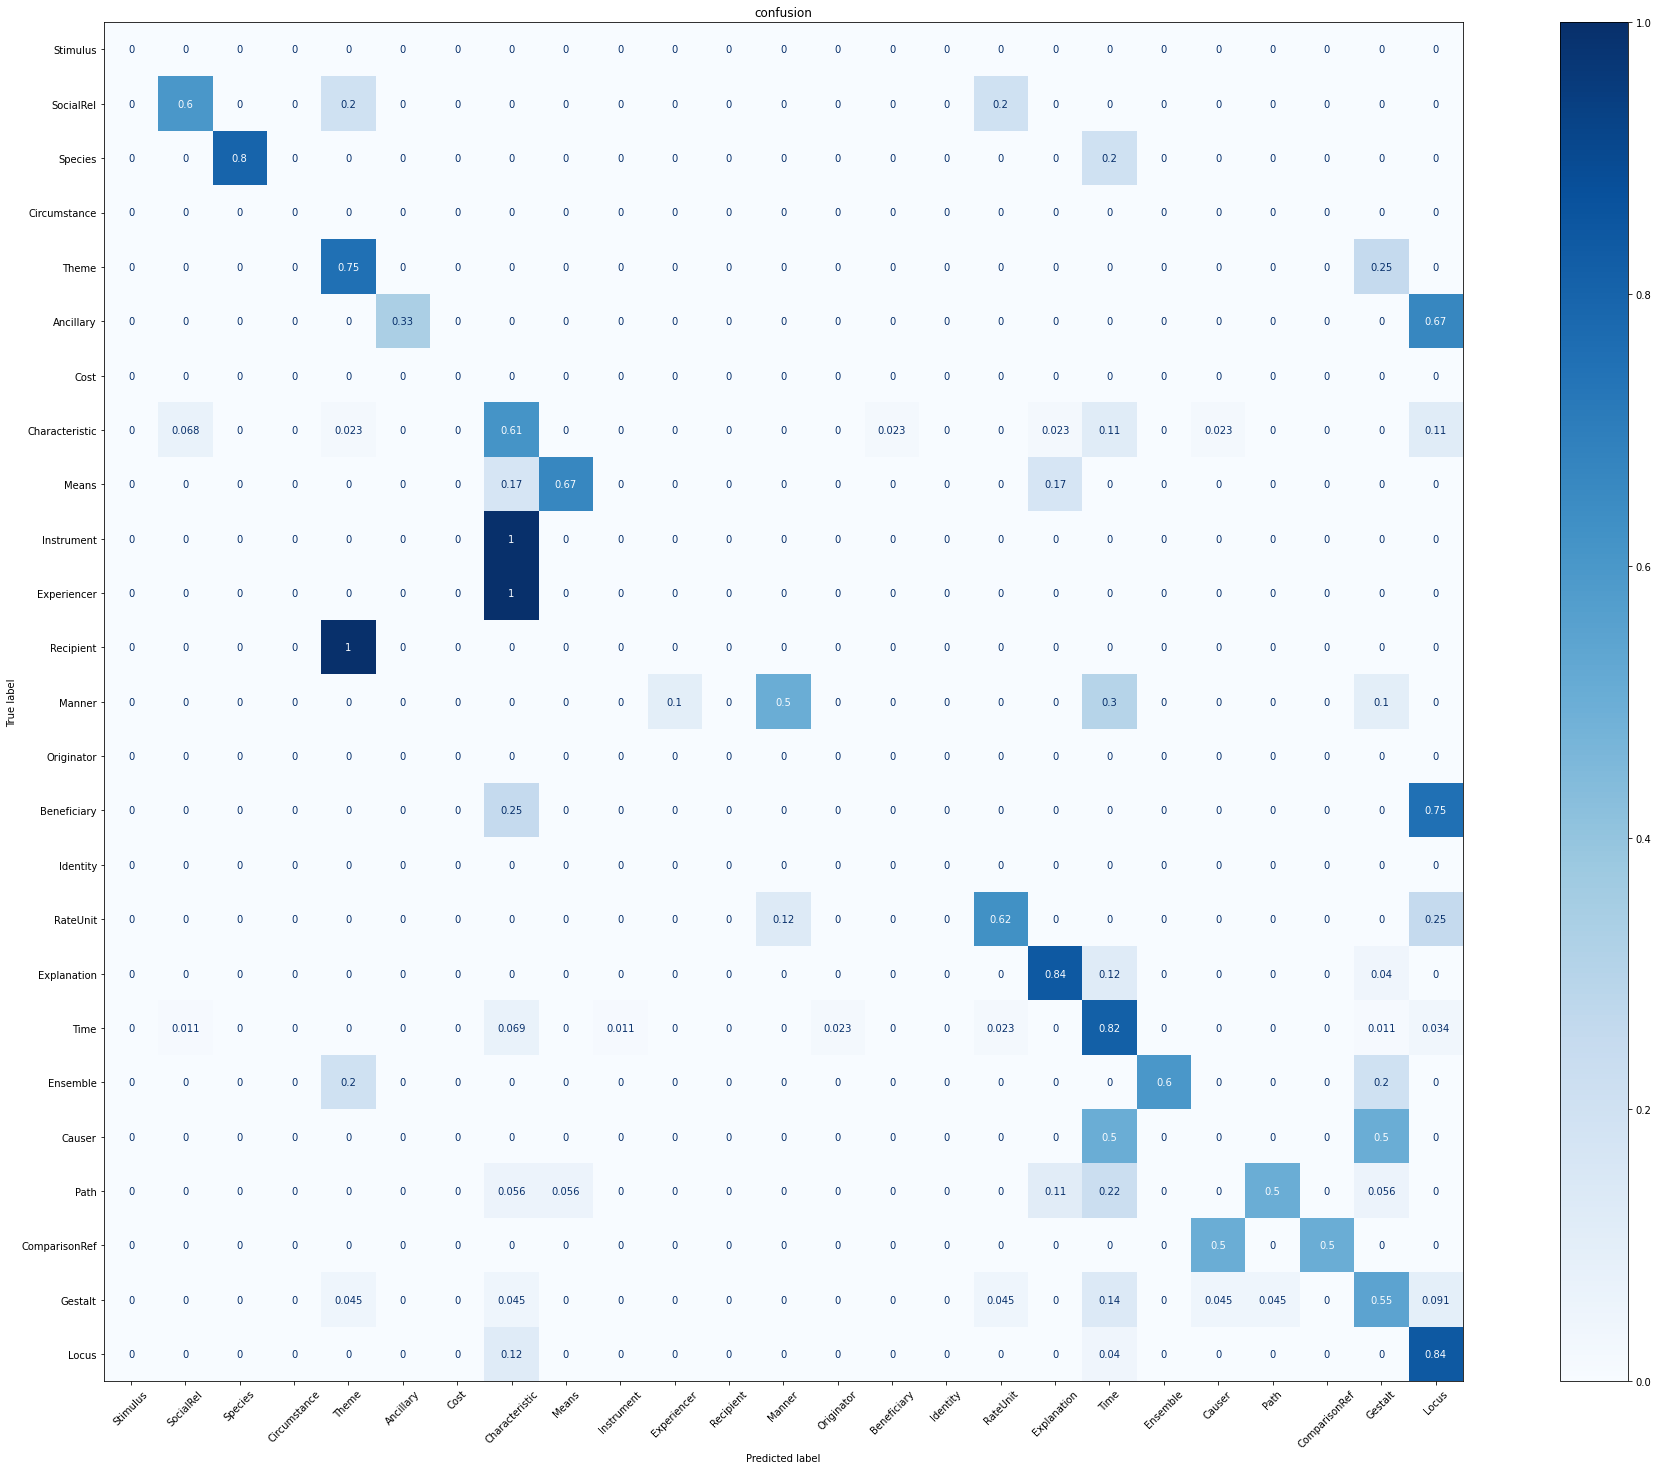

In [53]:
#t = LinearNNTrial(train_instances, dev_instances, test_instances, 'bert-large-cased-whole-word-masking', control=False, use_gov=True, use_obj=False)
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = all_supersenses

collapse_map = {
    'Purpose': 'Explanation',
    'Goal': 'Locus',
    'Source': 'Locus',
    'Direction': 'Path',
    'Extent': 'Path',
    'Duration': 'Time',
    'Frequency': 'Time',
    'StartTime': 'Time',
    'EndTime': 'Time',
    'Agent': 'Causer',
    'Topic': 'Theme',
    'Stuff': 'Characteristic',
    'PartPortion': 'Characteristic',
    'OrgMember': 'Characteristic',
    'Possession': 'Characteristic',
    'Approximator': 'Characteristic',
    'Org': 'Gestalt',
    'Possessor': 'Gestalt',
    'QuantityItem': 'Gestalt',
    'Whole': 'Gestalt',
}
assert all(k in labels for k in collapse_map.keys())
collapse_map_key_ids = [labels.index(k) for k in collapse_map.keys()]

def collapse(y, labels):
    new_y = []
    for i in y:
        if labels[i] in collapse_map:
            new_y.append(labels.index(collapse_map[labels[i]]))
        else:
            new_y.append(i)
    return new_y

def my_plot_confusion_matrix(y_pred, y_gold, labels, display_names):
    display_labels = labels
    cm = confusion_matrix(y_gold, y_pred, labels=labels, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[display_names[x] for x in labels])
    return disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)


def report(trial):
    print(trial)
    names = all_supersenses
    print(classification_report(trial.y_test, trial.preds, labels=range(45), target_names=names))
    print(list(enumerate(names)))
    
    disp = my_plot_confusion_matrix(
        collapse(trial.preds.flatten().tolist(), names),
        collapse(trial.y_test.flatten().tolist(), names),
        [i for i in range(45) if i not in collapse_map_key_ids],
        names
    )
    #disp = plot_confusion_matrix(
    #    t.model, 
    #    t.X_test,
    #    t.y_test,
    #    cmap=plt.cm.Blues,
    #    normalize='true',
    #    labels=range(45),
    #    display_labels=names,
    #    xticks_rotation=45,
    #)
    disp.ax_.set_title("confusion")
    disp.figure_.set_figwidth(35)
    disp.figure_.set_figheight(25)
    
report(t)